In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import datetime  # For datetime objects
from quantax.data_query_advance import local_get_stock_day_adv, local_get_index_day_adv

import numpy as np
import pandas as pd

# Import the backtrader platform
import backtrader as bt

import quantstats as qs

In [2]:
class BiasRatioCrossStrategy(bt.Strategy):
    params = (
        ('short', 20),
        ('mid', 60),
        ('long', 120)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add MovingAverageSimple indicator
        self.short = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.short)
        self.mid = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.mid)
        self.long = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.long)

        self.csr = (self.dataclose / self.short) - 1
        self.smr = (self.short / self.mid) - 1
        self.mlr = (self.mid / self.long) - 1

        # Indicators for the plotting show
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.csr > self.smr and self.smr > self.mlr and self.smr > self.smr[-1] and self.csr[-1] < self.smr[-1]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.csr < self.smr or self.csr < self.mlr or self.csr < 0:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [3]:

def prepare_data(code):
    print('reading data... {}'.format(code))
    data = local_get_stock_day_adv(code, start=datetime.date(2010, 1, 1).strftime('%Y-%m-%d'),
                                   end=datetime.datetime.today().strftime('%Y-%m-%d')).to_qfq()
    formatted = data.data.reset_index().loc[:, ['date', 'open', 'high', 'low', 'close', 'volume']]
    formatted.rename(columns={'date': 'datetime'}, inplace=True)
    return formatted.set_index('datetime')


In [18]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(BiasRatioCrossStrategy)

# Create a Data FeedRatio
stock_data = prepare_data('002414')
print('data samples:\n', stock_data.head())

data = bt.feeds.PandasData(dataname=stock_data,
                           fromdate=datetime.datetime(2014, 1, 1),
                           todate=datetime.datetime(2020, 11, 30))

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.PercentSizer, percents=80)

# Set the commission
cerebro.broker.setcommission(commission=0.0001)

cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.PositionsValue, _name='pos', cash=True)



reading data... 002414
data samples:
                 open      high       low     close    volume
datetime                                                    
2010-07-16  4.617814  4.820998  4.534693  4.704629  228739.0
2010-07-19  4.839469  5.079595  4.804374  4.990933  260221.0
2010-07-20  4.950297  5.236601  4.946602  5.123927  218849.0
2010-07-21  5.123927  5.162716  5.051889  5.090678  126467.0
2010-07-22  5.061124  5.135009  4.950297  5.070360  112106.0


In [19]:


# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
results = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


Starting Portfolio Value: 100000.00
2014-07-11, BUY CREATE, 8.16
2014-07-14, BUY EXECUTED, Price: 8.20, Cost: 80342.86, Comm 8.03
2014-07-15, SELL CREATE, 7.97
2014-07-16, SELL EXECUTED, Price: 7.95, Cost: 80342.86, Comm 7.79
2014-07-16, OPERATION PROFIT, GROSS -2438.10, NET -2453.92
2015-03-16, BUY CREATE, 9.61
2015-03-17, BUY EXECUTED, Price: 9.60, Cost: 78005.28, Comm 7.80
2015-03-18, SELL CREATE, 9.67
2015-03-19, SELL EXECUTED, Price: 9.65, Cost: 78005.28, Comm 7.84
2015-03-19, OPERATION PROFIT, GROSS 410.55, NET 394.91
2015-03-19, BUY CREATE, 9.84
2015-03-20, BUY EXECUTED, Price: 9.84, Cost: 78321.84, Comm 7.83
2015-03-20, SELL CREATE, 9.80
2015-03-23, SELL EXECUTED, Price: 9.80, Cost: 78321.84, Comm 7.80
2015-03-23, OPERATION PROFIT, GROSS -309.57, NET -325.21
2015-03-25, BUY CREATE, 10.40
2015-03-26, BUY EXECUTED, Price: 10.43, Cost: 78326.26, Comm 7.83
2015-03-30, SELL CREATE, 10.32
2015-03-31, SELL EXECUTED, Price: 10.32, Cost: 78326.26, Comm 7.75
2015-03-31, OPERATION PROFIT,

In [20]:
values = results[0].stats.broker.value.get(size=len(results[0].stats.broker.value))
values_list = list(values)
len(values_list)

1599

In [27]:
pos = results[0].analyzers.getbyname('pos').get_analysis()
pos_dt = pd.DataFrame(pos).T
pos_dt['values'] = values_list
pos_dt.head()

,0,1,values
2014-01-02,0.0,100000.0,100000.0
2014-01-03,0.0,100000.0,100000.0
2014-01-06,0.0,100000.0,100000.0
2014-01-07,0.0,100000.0,100000.0
2014-01-08,0.0,100000.0,100000.0


In [28]:
pos_dt = pos_dt.reset_index()
pos_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1599 non-null   object 
 1   0       1599 non-null   float64
 2   1       1599 non-null   float64
 3   values  1599 non-null   float64
dtypes: float64(3), object(1)
memory usage: 50.1+ KB


In [38]:
#pos_dt.rename(columns={'index':'date'}, inplace=True)
pos_dt['date'] = pos_dt['index'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
pos_dt = pos_dt.loc[:, ['date', 'values']].set_index('date')
pos_dt.head()

,values
date,
2014-01-02,100000.0
2014-01-03,100000.0
2014-01-06,100000.0
2014-01-07,100000.0
2014-01-08,100000.0


In [7]:
idx = local_get_index_day_adv('000906', start=datetime.date(2010, 1, 1).strftime('%Y-%m-%d'),
                              end=datetime.datetime.today().strftime('%Y-%m-%d'))
idx.data.close.head()

date        code  
2010-01-04  000906    3687.94
2010-01-05  000906    3719.95
2010-01-06  000906    3700.77
2010-01-07  000906    3627.18
2010-01-08  000906    3644.73
Name: close, dtype: float64

In [8]:
idx_data = idx.data.reset_index().loc[:,['date', 'close']].set_index('date')
idx_data.head()

,close
date,
2010-01-04,3687.94
2010-01-05,3719.95
2010-01-06,3700.77
2010-01-07,3627.18
2010-01-08,3644.73


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2014-01-02  2014-01-02
End Period                 2020-11-30  2020-11-30
Risk-Free Rate             0.0%        0.0%
Time in Market             5.0%        100.0%

Cumulative Return          13.73%      99.99%
CAGR%                      1.88%       10.54%
Sharpe                     0.29        0.58
Sortino                    0.5         0.73
Max Drawdown               -11.8%      -42.15%
Longest DD Days            1340        2043
Volatility (ann.)          8.12%       24.43%
R^2                        0.0         0.0
Calmar                     0.16        0.25
Skew                       5.29        -5.47
Kurtosis                   127.16      102.86

Expected Daily %           0.01%       0.04%
Expected Monthly %         0.16%       0.87%
Expected Yearly %          1.85%       10.41%
Kelly Criterion            2.73%       14.73%
Risk of Ruin               0.0%

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-04-14,2018-03-28,2018-12-14,1340,-11.797984,-11.146781
2,2018-12-17,2020-07-27,2020-11-30,714,-10.103667,-8.211339
3,2014-07-14,2015-03-26,2015-04-02,262,-3.881472,-3.188320
4,2015-04-08,2015-04-08,2015-04-09,1,-3.432248,0.000000


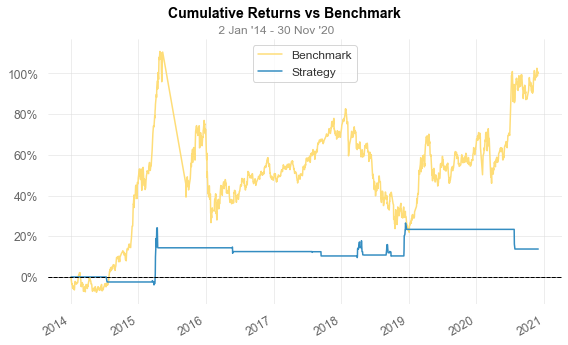

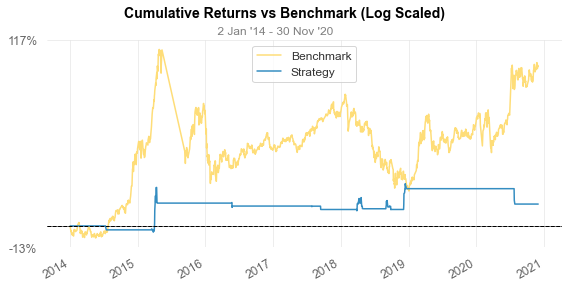

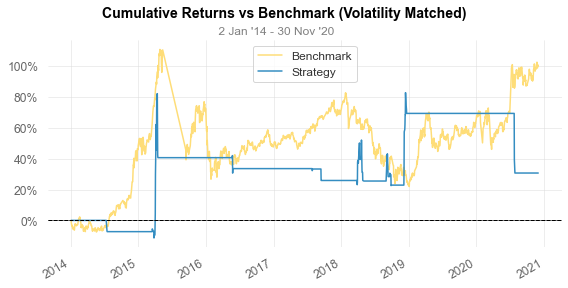

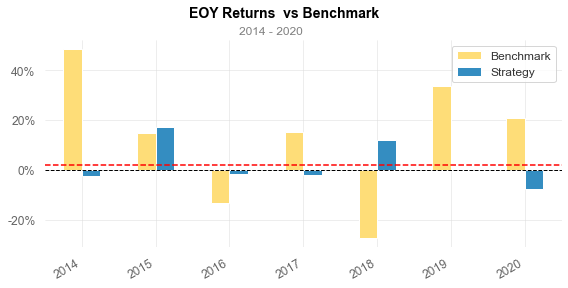

C:\MyProgram\anaconda\envs\trader\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


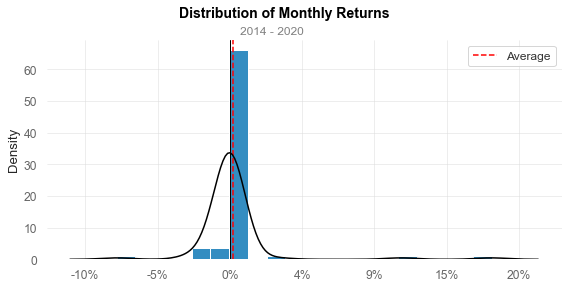

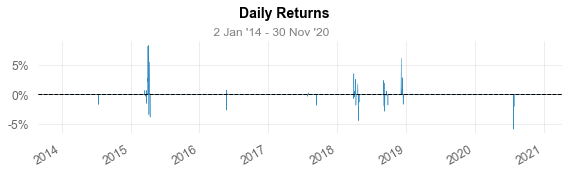

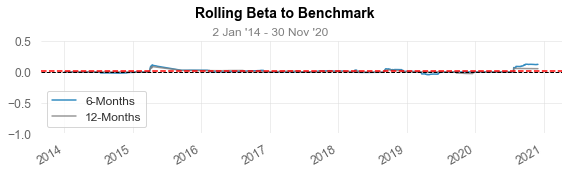

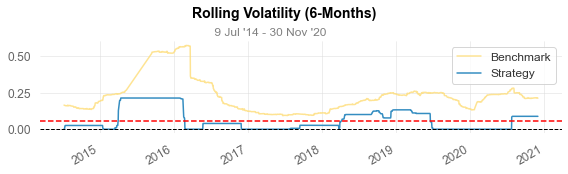

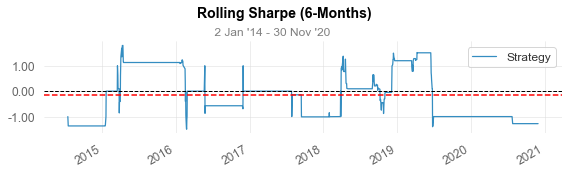

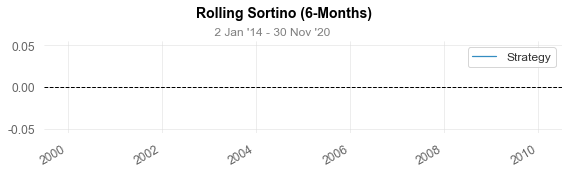

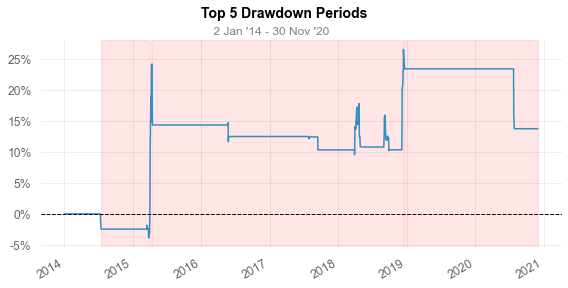

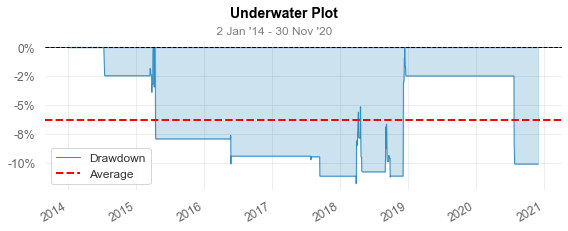

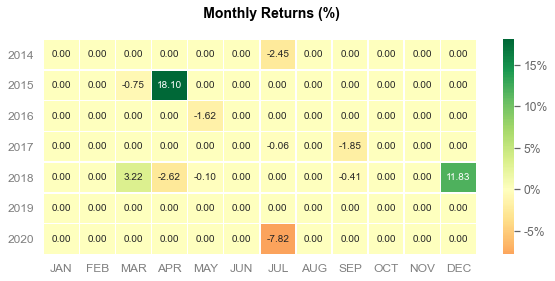

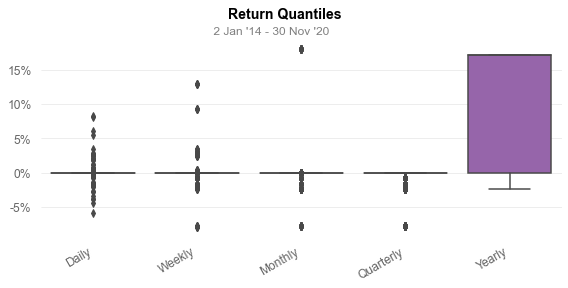

In [39]:
qs.reports.full(pos_dt['values'], idx_data['close'])